In [140]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy.interpolate import griddata

plt.style.use("ggplot")

In [211]:
def f(x,y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

In [212]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

In [234]:
points = np.random.rand(1000,2)
real_x = points[:, 0]
real_y = points[:, 1]
values = f(real_x, real_y)
# real_x = np.linspace(0, 1, 26)
# real_y = np.linspace(0, 1, 26)
# values = f(real_x, real_y)

print(grid_x.shape)
print(grid_y.shape)
print(real_x.shape)
print(real_y.shape)
print(values.shape)

(100, 100)
(100, 100)
(1000,)
(1000,)
(1000,)


In [235]:
grid_z0 = griddata((real_x, real_y), values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata((real_x, real_y), values, (grid_x, grid_y), method='linear')
grid_z2 = griddata((real_x, real_y), values, (grid_x, grid_y), method='cubic')

/Users/James/anaconda/envs/senior-design/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


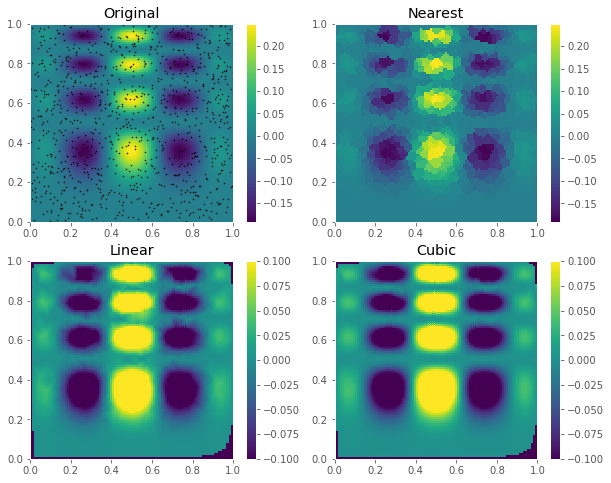

In [236]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(221)
ax.plot(points[:,0], points[:,1], 'k.', ms=1)
heatmap = ax.pcolor(grid_x, grid_y, f(grid_x, grid_y))
fig.colorbar(heatmap)
ax.set_title("Original")

ax = fig.add_subplot(222)
heatmap = ax.pcolor(grid_x, grid_y, grid_z0)
fig.colorbar(heatmap)
ax.set_title("Nearest")

ax = fig.add_subplot(223)
heatmap = ax.pcolor(grid_x, grid_y, grid_z1)
fig.colorbar(heatmap)
ax.set_title("Linear")

ax = fig.add_subplot(224)
heatmap = ax.pcolor(grid_x, grid_y, grid_z2)
fig.colorbar(heatmap)
ax.set_title("Cubic")

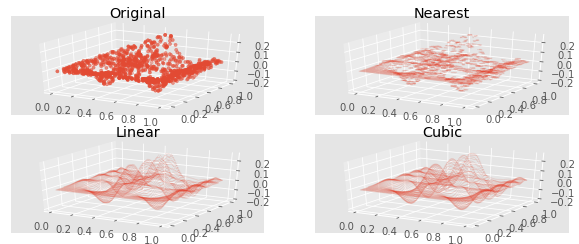

In [237]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(221, projection='3d')

ax.scatter(real_x, real_y, values, s=10)
ax.set_title("Original")

ax = fig.add_subplot(222, projection='3d')
ax.scatter(grid_x, grid_y, grid_z0, s=.5, alpha=.1)
ax.set_title("Nearest")

ax = fig.add_subplot(223, projection='3d')
ax.scatter(grid_x, grid_y, grid_z1, s=.5, alpha=.1)
ax.set_title("Linear")

ax = fig.add_subplot(224, projection='3d')
ax.scatter(grid_x, grid_y, grid_z2, s=.5, alpha=.1)
ax.set_title("Cubic")

In [13]:
argm = np.argmax(f(grid_x, grid_y))
print(np.ravel(f(grid_x, grid_y))[argm])
x = np.ravel(grid_x)[argm]
y = np.ravel(grid_y)[argm]
f(x,y)
print(x)
print(y)

0.249471206464
0.494949494949
0.353535353535


In [276]:
grid_elem, grid_feat = np.mgrid[0:5000:25, 0:1000:25]

In [267]:
# real_elem = np.linspace(0, 5000, 21)
# real_feat = np.linspace(0, 1000, 21)
real_elem = np.random.randint(0, 5000, 100)
real_elem[0] = 0
real_elem[1] = 5000
real_elem[2] = 0
real_elem[3] = 5000
real_feat = np.random.randint(0, 1000, 100)
real_feat[0] = 0
real_feat[1] = 1000
real_feat[2] = 1000
real_feat[3] = 0
real_scores = np.random.rand(len(real_elem))

print(grid_elem.shape)
print(grid_feat.shape)
print(real_elem.shape)
print(real_feat.shape)
print(real_scores.shape)

(200, 40)
(200, 40)
(100,)
(100,)
(100,)


In [277]:
grid_scores0 = griddata((real_elem, real_feat), real_scores, (grid_elem, grid_feat), method='nearest')
grid_scores1 = griddata((real_elem, real_feat), real_scores, (grid_elem, grid_feat), method='linear')
grid_scores2 = griddata((real_elem, real_feat), real_scores, (grid_elem, grid_feat), method='cubic')

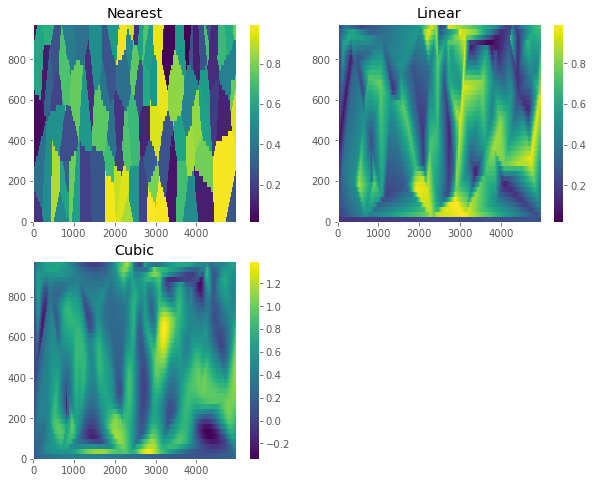

In [278]:
fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(221)
# ax.plot(points[:,0], points[:,1], 'k.', ms=1)
# heatmap = ax.pcolor(grid_x, grid_y, f(grid_x, grid_y))
# fig.colorbar(heatmap)
# ax.set_title("Original")

ax = fig.add_subplot(221)
heatmap = ax.pcolor(grid_elem, grid_feat, grid_scores0)
fig.colorbar(heatmap)
ax.set_title("Nearest")

ax = fig.add_subplot(222)
heatmap = ax.pcolor(grid_elem, grid_feat, grid_scores1)
fig.colorbar(heatmap)
ax.set_title("Linear")

ax = fig.add_subplot(223)
heatmap = ax.pcolor(grid_elem, grid_feat, grid_scores2)
fig.colorbar(heatmap)
ax.set_title("Cubic")

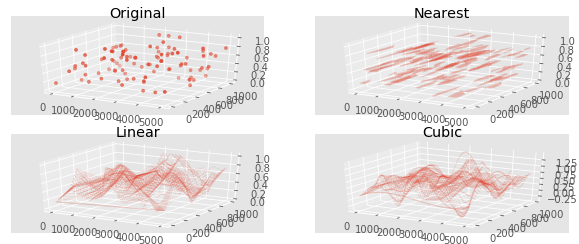

In [279]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(221, projection='3d')
ax.scatter(real_elem, real_feat, real_scores, s=10)
ax.set_title("Original")

ax = fig.add_subplot(222, projection='3d')
ax.scatter(grid_elem, grid_feat, grid_scores0, s=.5, alpha=.1)
ax.set_title("Nearest")

ax = fig.add_subplot(223, projection='3d')
ax.scatter(grid_elem, grid_feat, grid_scores1, s=.5, alpha=.1)
ax.set_title("Linear")

ax = fig.add_subplot(224, projection='3d')
ax.scatter(grid_elem, grid_feat, grid_scores2, s=.5, alpha=.1)
ax.set_title("Cubic")